In [1]:

#hide
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [49]:
from fastbook import plot_function

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
dblock = DataBlock()

In [5]:
dsets = dblock.datasets(df)

In [6]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [7]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [8]:
x['fname']

'008663.jpg'

In [9]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [10]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [11]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/home/ubuntu/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [12]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [13]:
idxs = torch.where(dsets.train[0][1] == 1)
dsets.train.vocab[idxs]

(#1) ['dog']

In [14]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                   get_x=get_x, get_y=get_y, 
                   splitter=splitter)

datasets = dblock.datasets(df)
datasets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

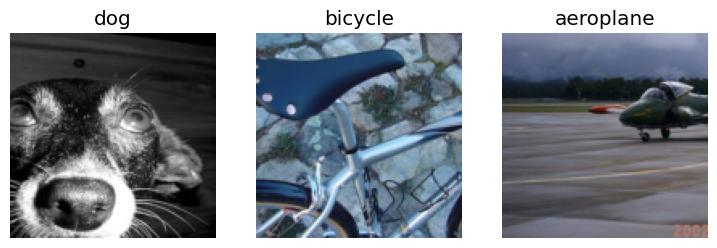

In [16]:
dls.show_batch(nrows=1, ncols=3)

In [17]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [18]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape, x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [19]:
learn = vision_learner(dls, resnet18)

In [20]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [21]:
activs[0]

TensorImage([ 1.6641, -1.3767,  0.1505,  3.4072,  0.4143, -2.3914,  2.6735,  2.7899,  1.8520, -1.3008, -0.5707, -0.6513,  2.8487,  1.6975,  0.4636, -1.9360, -3.9222, -0.0771, -1.0041, -1.5650],
            grad_fn=<AliasBackward0>)

In [22]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [23]:
loss_func = nn.BCEWithLogitsLoss()
# loss = loss_func(activs, y)
loss = loss_func(TensorBase(activs), TensorBase(y))

loss

TensorBase(1.0877, grad_fn=<AliasBackward0>)

In [24]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 74.1MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.953707,0.687586,0.242271,00:06
1,0.825050,0.542497,0.291056,00:05
2,0.603379,0.189418,0.837650,00:05
3,0.359974,0.117187,0.942789,00:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132462,0.102465,0.954761,00:06
1,0.114608,0.096909,0.959123,00:06
2,0.099460,0.094223,0.957709,00:06


In [25]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09422297030687332,0.9386453032493591]

In [26]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09422297030687332,0.9424899816513062]

In [27]:
preds,targs = learn.get_preds()

In [28]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9588)

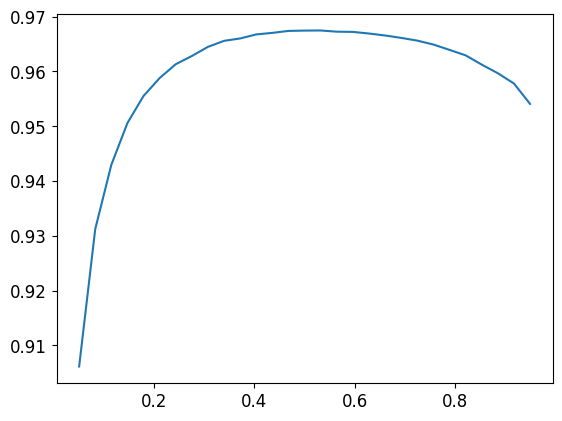

In [29]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

In [30]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [31]:
Path.BASE_PATH = path

In [32]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [33]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [34]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('11/frame_00394_pose.txt')

In [35]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

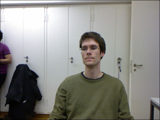

In [36]:
im.to_thumb(160)

In [37]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [38]:
get_ctr(img_files[0])

tensor([367.1510, 204.8200])

In [39]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

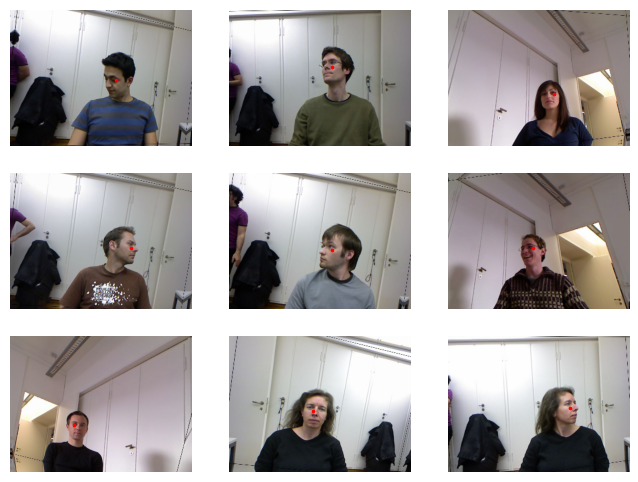

In [40]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [41]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [42]:
yb[0]

TensorPoint([[-0.2694, -0.1284]], device='cuda:0')

In [46]:
xb[0][0][1].shape

torch.Size([320])

In [47]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [51]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

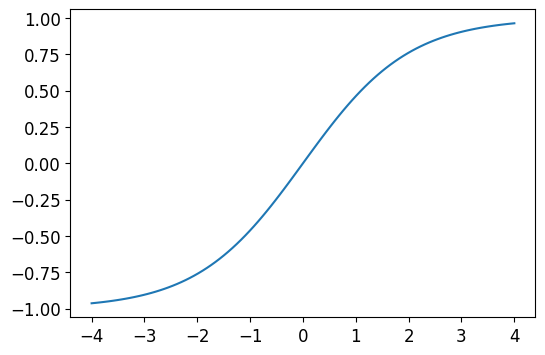

In [52]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [53]:
dls.loss_func

FlattenedLoss of MSELoss()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torc

SuggestedLRs(valley=0.0012022644514217973)

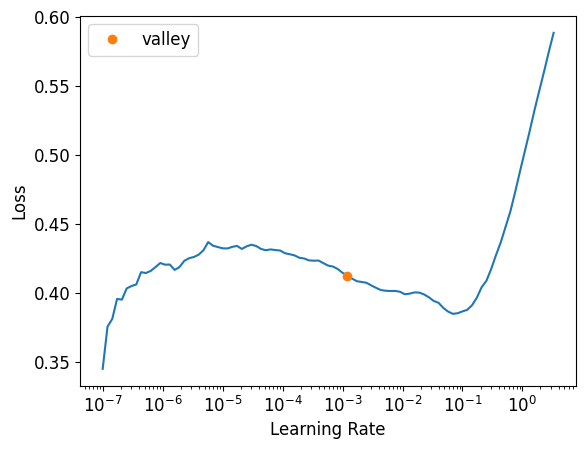

In [54]:
learn.lr_find()

In [55]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.048596,0.004586,00:32


epoch,train_loss,valid_loss,time
0,0.008087,0.002111,00:41
1,0.003229,0.000243,00:41
2,0.001480,0.000090,00:41


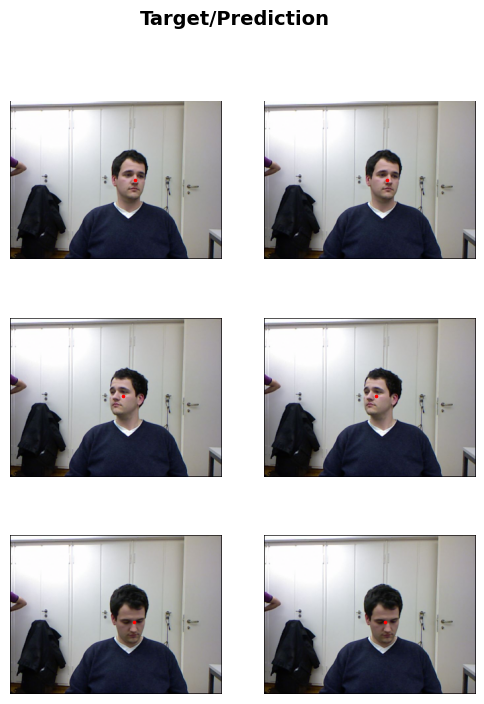

In [56]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))